<a href="https://colab.research.google.com/github/shantam-8/ML-Materials-Individual-Project/blob/main/Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Project

In [ ]:
# import numpy as np

# # Insert your values
# Name = "Shantam Gilra" # Replace with your name
# CID = 1878023 # Replace with your College ID (as a numeric value with no leading 0s)

# # Set a random seed using the CID value
# CID = int(CID)
# np.random.seed(CID)

# # Print the message
# print("This is the work of " + Name + " [CID: " + str(CID) + "]")

## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

# Libraries Used

In [3]:
# Installation of libraries
!pip install matminer=="0.9.0" --quiet
!pip install pymatgen=="2023.09.25" --quiet
!pip install xgboost --quiet
!pip install elementembeddings --quiet
!pip install lightgbm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.2/677.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.7/807.7 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
# !pip install CBFV --user

# !pip install -U xenonpy

# !pip install parallel-pandas --user

In [1]:
# Import of modules
import numpy as np  # Numerical operations
from pymatgen.core import Structure, Composition  # Materials analysis for crystal structures
import pandas as pd  # Data manipulation with DataFrames
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets

import plotly.express as px

from elementembeddings.core import Embedding

# To make the model run faster
teaching_mode = True

# Data Preparation



In [2]:
df = load_dataset("matbench_expt_gap")

df.head(10)

Fetching matbench_expt_gap.json.gz from https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz to /usr/local/lib/python3.10/dist-packages/matminer/datasets/matbench_expt_gap.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz in MB: 0.038911999999999995MB [00:00, 12.53MB/s]   


,composition,gap expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00
5,Ag2BiO3,0.00
6,Ag2GeS3,1.98
7,Ag2GeSe3,0.90
8,Ag2HgI4,2.47
9,Ag2Mo(I2O7)2,3.06


In [ ]:
# from matminer.featurizers.composition.element import BandCenter
# from matminer.featurizers.composition.ion import IonProperty, ElectronegativityDiff, OxidationStates

# from elementembeddings.composition import composition_featuriser, CompositionalEmbedding

# from matminer.featurizers.composition.composite import ElementProperty
# # # Sample composition data
# # composition_data = {'Fe': 0.5, 'O': 0.5}

# # # Convert composition data into a Pymatgen Composition object
# # composition = Composition(composition_data)

# # # Create an instance of the BandCenter featurizer
# # bc = BandCenter()

# # # Apply the featurizer to your composition data
# # band_centers = bc.featurize(composition)

# # print(band_centers)

# # l = 0
# # for i in df["composition"]:
# #     try:
# #         print(ElementProperty.from_preset(preset_name="magpie").featurize(Composition(CompositionalEmbedding(i, "magpie").fractional_composition)))
# #     except KeyError:
# #         l = l + 1
# # print(l)

# # df1 = pd.DataFrame()



# # # Iterate over rows in the DataFrame
# # for index, row in df.iterrows():
# #     # Create a Composition object from the composition data
# #     composition = Composition(row['composition'])
# #     # Featurize the composition using CompositionalEmbedding with "magpie" preset
# #     featurized_composition = CompositionalEmbedding(composition, "magpie").fractional_composition
# #     # Store the featurized composition in the 'fractional_composition' column of df_featurised
# #     df_featurised.at[index, 'fractional_composition'] = featurized_composition

# # print(df_featurised)

# # # # Adding column to include band centers
# # # OxidationStates().featurize("ZrTiF6")

# # from matminer.featurizers.composition import ElementProperty
# # import pandas as pd

# # # Sample composition DataFrame
# # composition_df = pd.DataFrame({'composition': [{'Fe': 0.5, 'O': 0.5}, {'Al': 0.4, 'O': 0.3, 'N': 0.3}]})

# # # Create an instance of the ElementProperty featurizer with ElectronAffinity property
# # ep = ElementProperty.from_preset(preset_name="magpie")

# # # Apply the featurizer to the composition DataFrame
# # featurized_df = ep.featurize_dataframe(composition_df, col_id='composition')

# # print(featurized_df)

# # Function to calculate fractional composition

# df = df.sample(1000)

# # Apply the function to create the new column
# df['fractional_composition'] = df['composition'].apply(lambda x: Composition(x).fractional_composition)
# df["oxidation_states"] = df['composition'].apply(lambda x: Composition(x).add_charges_from_oxi_state_guesses())


# # df1 = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id='fractional_composition')
# # df2 = BandCenter().featurize_dataframe(df, col_id='fractional_composition', ignore_errors=True)


# df3 = OxidationStates().featurize_dataframe(df = df, col_id='oxidation_states', ignore_errors=True)



# df3

In order to correctly featurise the dataset given, different featurisers from Maminer and Element Embeddings were used. It was likely that different statistical elements (minimum, maximum, range, mean, avg_dev and mode) of different Magpie properties would be important to accurately predict the band gap. Hence, all statistical elements of all Magpie properties were added to the featurised dataset. This was followed by an addition to one-hot encoded columns of atomic structure and properties like the band center.

In [3]:
# Featurising df
from elementembeddings.composition import composition_featuriser, CompositionalEmbedding
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.composition.element import BandCenter

# Adding fractional composition column to main database.
df['fractional_composition'] = df['composition'].apply(lambda x: Composition(x).fractional_composition)

# Featurising based on magpie data using fractional composition.
df_featurised = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id='fractional_composition')

# Featurising by adding one-hot collumns of each compound
composition_df = composition_featuriser(df_featurised["composition"], embedding="atomic", stats=["sum"])
df_featurised = pd.concat([df_featurised, composition_df], axis=1)

# Featurising by adding one-hot collumns of each compound
bandcenter_df = BandCenter().featurize_dataframe(df, col_id='fractional_composition', ignore_errors=True)
df_featurised = pd.concat([df_featurised, bandcenter_df], axis=1)

# Adding column that includes number of atoms in each compound
df_featurised["num_atoms"] = df["composition"].apply(lambda x: CompositionalEmbedding(x, "magpie").num_atoms)

# Drop duplicate columns
df_featurised = df_featurised.T.drop_duplicates().T

# Drop non-featurised columns
df_featurised = df_featurised.drop(["composition", "gap expt", "fractional_composition"], axis=1)

df_featurised

ElementProperty:   0%|          | 0/4604 [00:00<?, ?it/s]

Featurising compositions...


100%|██████████| 4604/4604 [00:06<00:00, 746.28it/s]


Computing feature vectors...


100%|██████████| 4604/4604 [00:00<00:00, 147946.55it/s]


BandCenter:   0%|          | 0/4604 [00:00<?, ?it/s]

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,sum_Pt,sum_Au,sum_Hg,sum_Tl,sum_Pb,sum_Bi,sum_Th,sum_U,band center,num_atoms
0,16.0,79.0,63.0,47.4,25.28,16.0,65.0,88.0,23.0,74.6,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.640081,5.0
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.330247,21.0
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0,5.198208,7.25
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0,5.0443,7.25
4,5.0,47.0,42.0,33.5,14.25,47.0,65.0,95.0,30.0,74.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.032223,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,7.0,73.0,66.0,26.8,23.76,7.0,44.0,82.0,38.0,67.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.627749,5.0
4600,40.0,52.0,12.0,46.0,6.0,40.0,44.0,90.0,46.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.402714,2.0
4601,8.0,40.0,32.0,23.0,8.5,22.0,43.0,87.0,44.0,54.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.221115,4.0
4602,9.0,40.0,31.0,14.5,8.25,9.0,43.0,93.0,50.0,80.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.923077,8.0


It was not clear as to which features are important and training models with non-important features would increase computation costs and would decrease the model's accuracy. Hence, a preliminary Random Forest regressor was trained on the whole dataset to derive the feature importances of all features. This was represented in two different ways - a bar chart containing the feature importances of different features and a plot of one decision tree of the random forest ensemble.

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Define the features we want in the DataFrame
feature_cols = [col for col in list(df_featurised.columns) if col != "formula"]

# Get an array of the features
prelim_X = df_featurised[feature_cols]

# Get an array of the target variable
y = df["gap expt"]

# Training a preliminary random forest regressor to understand the importance of different features
prelim_rf = RandomForestRegressor()
prelim_rf.fit(prelim_X, y)

RandomForestRegressor()

In [5]:
# Load the atomic data
atomic_feature_labels = Embedding.load_data('atomic').feature_labels
one_hot_columns = ["sum_" + a for a in atomic_feature_labels]


# Get index of all one-hot encoded element columns to sum their feature importances
imp = prelim_rf.feature_importances_
feature_col = prelim_X.columns

elem_indices = [np.where(np.isin(prelim_X.columns, one_hot_columns))[0]]
elem_imp = imp[np.where(np.isin(prelim_X.columns, one_hot_columns))[0]].sum()

# Removing individual element contributions and adding them together
imp = np.delete(imp, elem_indices)
imp = np.append(imp, elem_imp)

# Removing individual element columns and adding "Elements"
feature_col = np.delete(feature_col, elem_indices)
feature_col = np.append(feature_col, "Elements")

# Sorting both arrays based on descending order of importances
sort_inds = imp.argsort()
imp = imp[sort_inds[::-1]]
feature_col = feature_col[sort_inds[::-1]]

# Plot the bar chart containing the feature importances of different features
fig = px.bar(x = feature_col, y = imp,
             labels={"x": "Preliminary Feature Columns", "y": "Feature Importances"},
             title="Feature Importance Bar Chart")

fig.update_xaxes(tickfont=dict(size = 7.5))
fig.show()

The chart signifies the importance of added features like the one-hot encoded atomic data and band center. However, as the band center values could not be derived for "Th" and "U" based compositions, compositions containing those elements were removed from the training and testing datasets. Furthermore, all features after "MagpieData range GSmagmom" have very less importance values (<0.001). Hence, these features were removed as well.

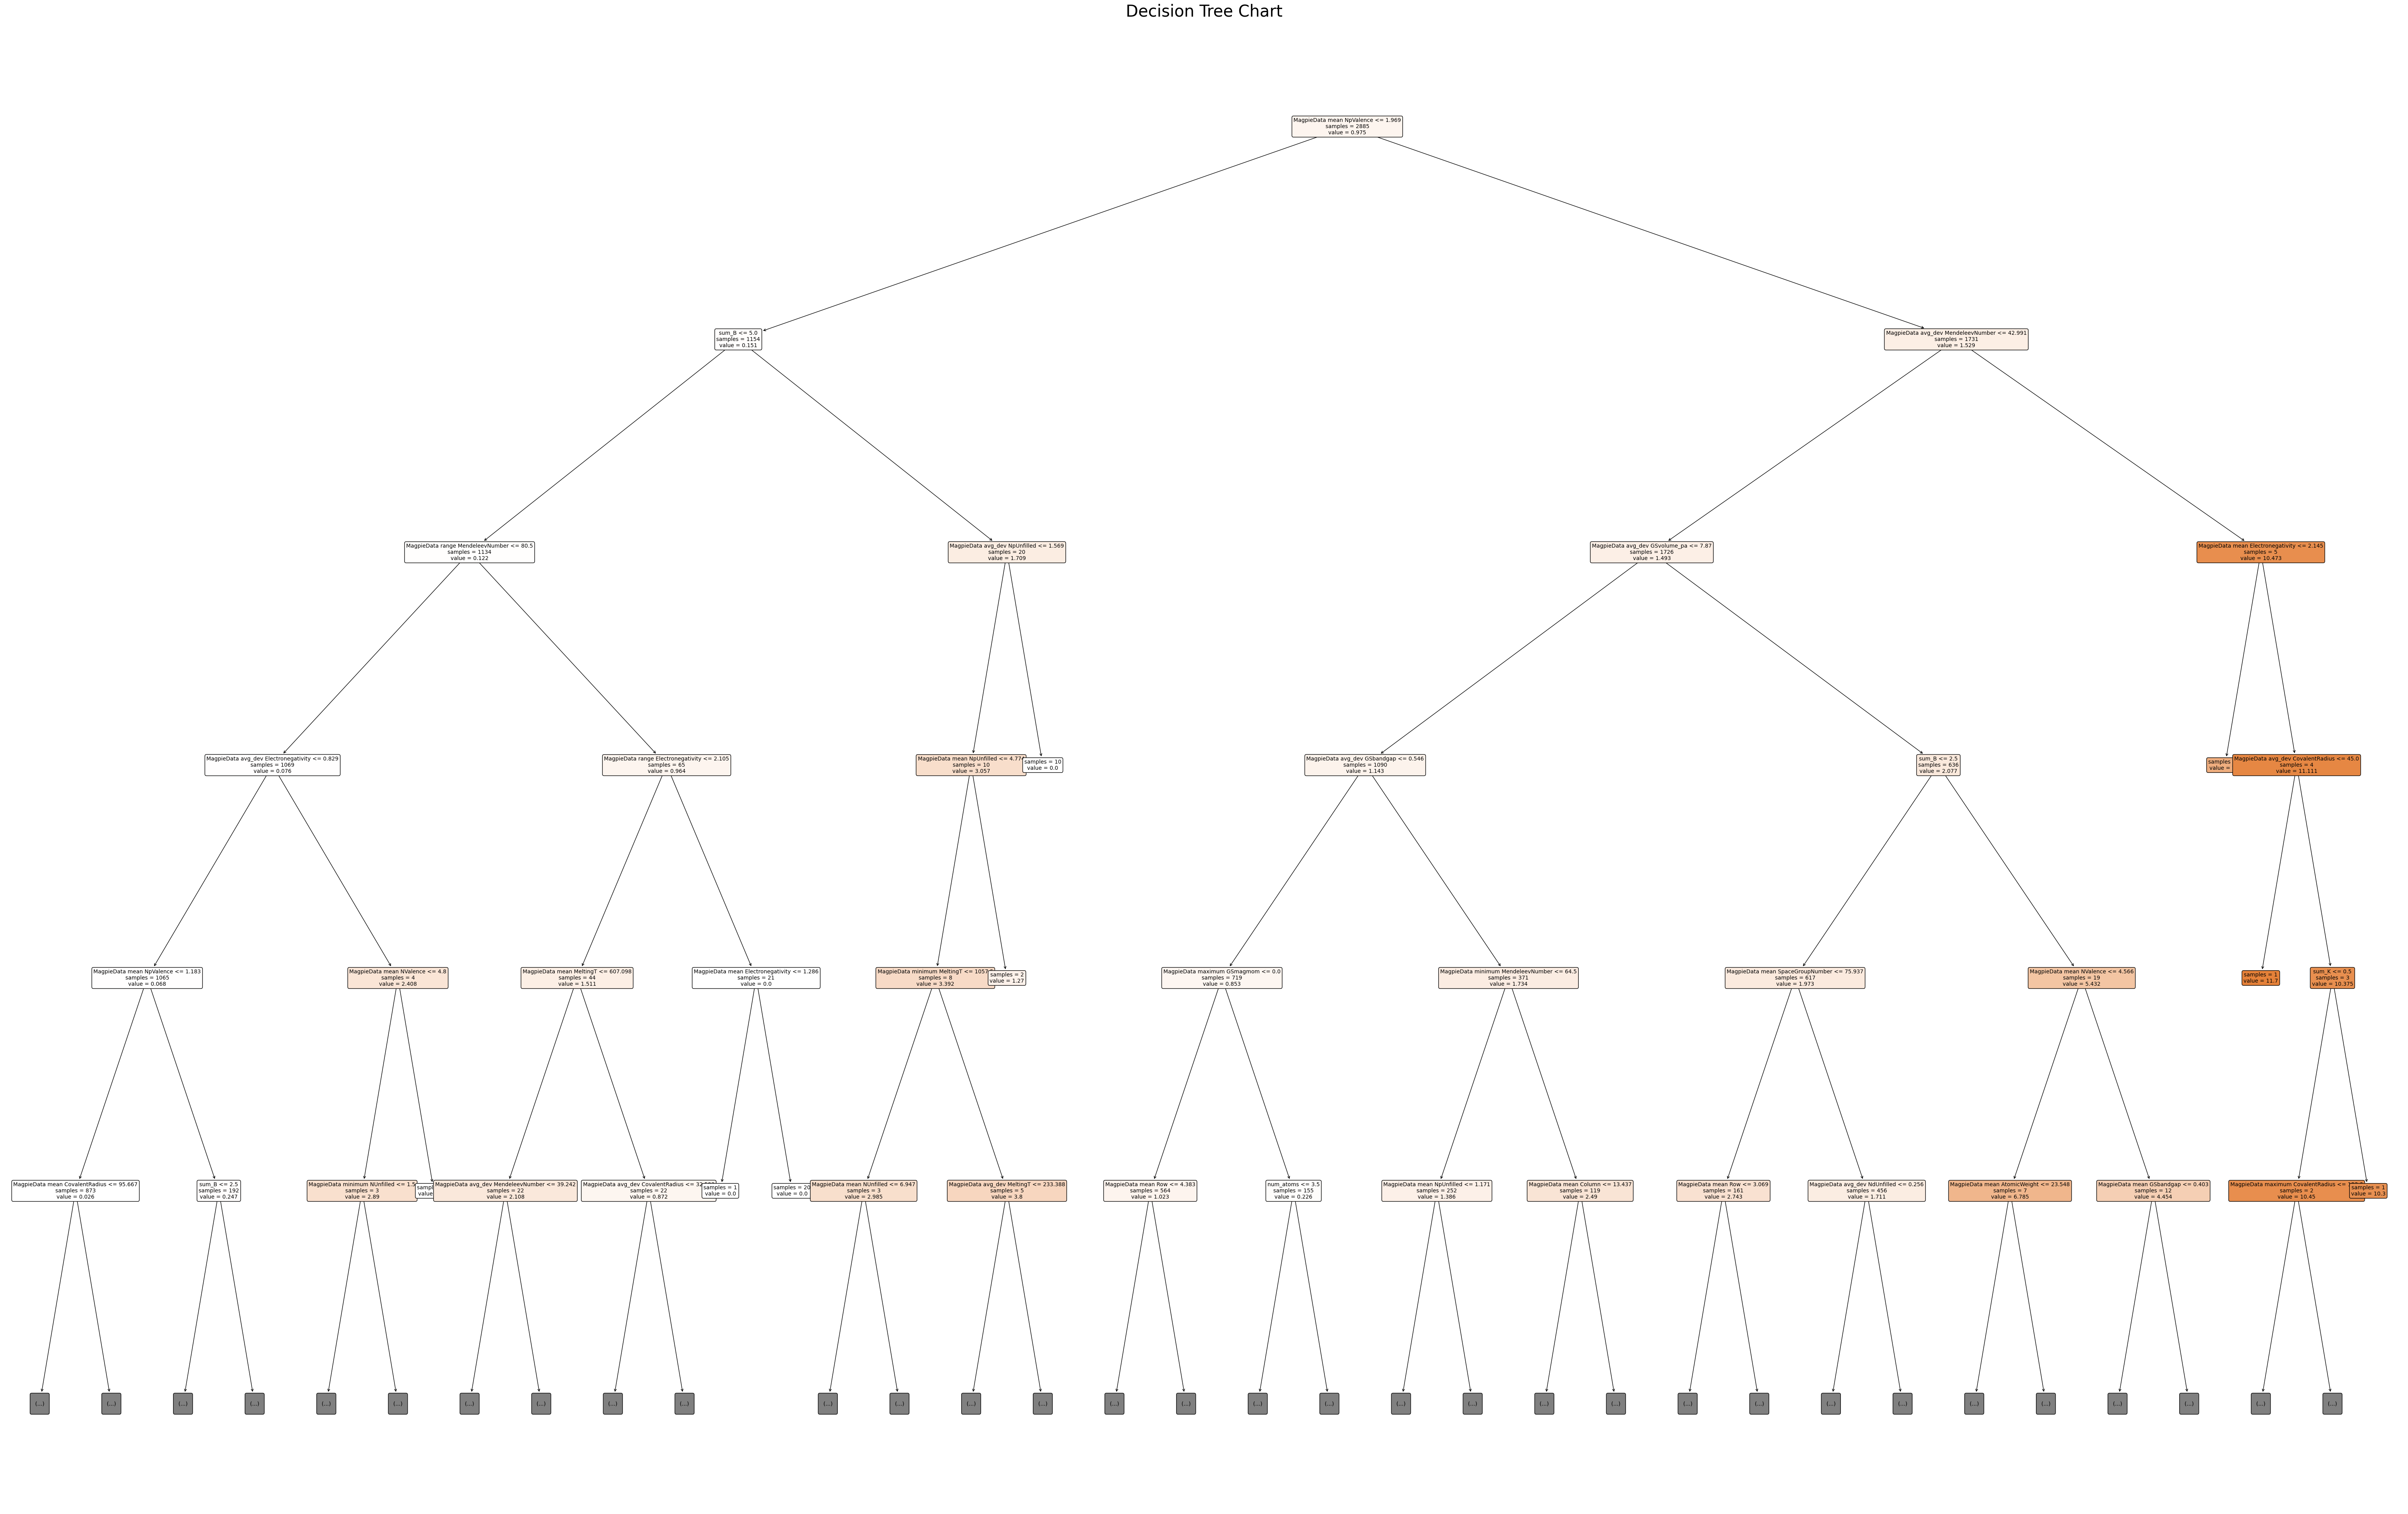

In [6]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot a chart of one decision tree in the random forest ensemble (click on the graph to zoom it)
plt.figure(figsize=(80, 50))
_ = tree.plot_tree(prelim_rf.estimators_[0], max_depth = 5, feature_names = df_featurised.columns, filled = True, rounded = True, fontsize = 10, impurity = False)
plt.title("Decision Tree Chart", fontsize = 30)
plt.show()

While the chart further amplified the importance of "MagpieData mean NpValence", it also showed the high extremity (darker shades of the box depict higher extremity) of compositions specific properties. This indicates that the predicted values of some compositions would have high deviations from the actual values.

While these compositions could be filtered out of the training and testing datasets, these were still left in the dataset as it can be possible that other decision trees in the ensemble or other models can accurately predict the band gap.

In [7]:
# Remove all column values in the featurised dataset with a lower feature importance than "MagpieData range GSmagmom"
X = df_featurised.drop(feature_col[np.where(feature_col == "MagpieData range GSmagmom")[0][0] + 1:], axis=1)

# Remove all NaN values. Maintaining the index to easily determine the actual composition in the raw dataset "df".
X = X.dropna()

The final dataset has 4480 compositions after removing 124 compositions from the main dataset.
The distribution of band gap values was then explored in the context of the features by reducing the number of dimensions to three using PCA.

In [8]:
from sklearn.decomposition import PCA

# Performing a 3 axes PCA on the featurised dataset
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(X)

# Plotting 3D scatter plot
fig = px.scatter_3d (x = transformed_data[:, 0], y = transformed_data[:, 1], z = transformed_data[:, 2], color = df["gap expt"][X.index],
                     labels = {"x": "PCA X-axis", "y": "PCA Y-axis", "z": "PCA Z-axis", "color": "Band Gap"},
                     title = "PCA 3D Scatter Plot")

fig.update_layout(scene_camera = dict(eye = dict(x=0, y=0, z=1.5)))
fig.show()

The 3D Scatter plot is displayed on a specific camera angle to depict the relative postion of compositions having high and low band gaps - as seen, high band gaps are typically form a cluster in the left region. While the PCA did not have any information regarding the band gap, it was able to loosely seperate the high and low band gap compounds - hence, justifying the validity of the featurised dataset.

However, the 3D scatter plot also indicates the dominance of compositions with a low band gap. This distribution is further explored using a histogram.

In [53]:
# Plotting histogram of Band Gaps
fig = px.histogram(x = df["gap expt"][X.index],
                   nbins = 12,
                   marginal = "box",
                   labels = {"x": "Band Gap"},
                   title = "Distribution of Band Gaps")

fig.show()

Due to the comparatively high number of low band gaps as seen by the box plot and graph, the training and testing datasets can be split using a stratified split rather than a random split. This may ensure that the model will be more robust and accurate. However, to create preliminary models, a random split will be used.

# Training and Testing

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Standard scaling of featurised dataset for different models.
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Target Values
y = df["gap expt"][X.index]

# Splitting train and test values
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.4, random_state=42)

In [16]:
def scoring(X_train, X_test, y_train, y_test, model):

  # Cross Validation
  cv_scores = cross_validate(model, X_train, y_train, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), n_jobs = -1)
  y_pred = model.predict(X_test)

  # Testing Metrics
  test_mse = np.sqrt(mean_absolute_error(y_test, y_pred))
  test_r2 = r2_score(y_test, y_pred)

  metrics_list = [str(model.__class__.__name__),
                  np.sqrt(np.mean(abs(cv_scores["test_neg_mean_squared_error"]))),
                  np.mean(abs(cv_scores["test_r2"])),
                  test_mse,
                  test_r2,
                  np.mean(cv_scores["fit_time"])]

  return metrics_list

In [1]:
import pprint

In [2]:
# Setting up DataFrame object to hold data
metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "Test RMSE (eV)", "Test R2", "Time (s)"])

# Models List
models = [
    RandomForestRegressor(n_jobs = -1),
    SVR(),
    xg.XGBRegressor(n_jobs = -1),
    KernelRidge(),
    KNeighborsRegressor(n_jobs = -1),
    LGBMRegressor(n_jobs = -1, verbose = -1),
    GradientBoostingRegressor()
    ]

# Loop to run different models
for model in models:
  model = model
  model.fit(X_train, y_train)
  metrics_df.loc[len(metrics_df)] = scoring(X_train, X_test, y_train, y_test, model)

metrics_df

NameError: name 'pd' is not defined

## Training and testing

Train, validate and test your model. Comment on the performance metrics. Note the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model.

<details>
<summary>Note on the ROC-AUC classification metric</summary>
There is one metric we didn't cover but is used in Matbench. In binary classification models, the ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score can be used to evaluate performance. It quantifies the ability of the model to distinguish between positive and negative instances across different decision thresholds. A higher ROC-AUC score (ranging from 0.5 to 1) indicates better performance, with 1 representing a perfect classifier and 0.5 indicating performance no better than random chance. There is a more detailed discussion on https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

The metric can be calculated using the `roc_auc_score` function from the `sklearn.metrics` module, e.g.

```python
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob)
y_true = [...]  
y_pred_prob = [...]  

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Display the result
print(f'ROC-AUC Score: {roc_auc:.4f}')
```
</details>

In [ ]:
# Spare cell




## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell




## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page.

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).